In [258]:
library(rdmc)
library(tidyverse)
library(ape)
theme_set(cowplot::theme_cowplot(15))
library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)


In [272]:
FREQ_POPS = c(
    "chrom",
    "start",
    "end",
    "v5--LR--Amatlan_de_Canas",
    "v5--LR--Crucero_Lagunitas",
    "v5--LR--Los_Guajes",
    "v5--LR--random1_Palmar_Chico",
    "v5--LR--San_Lorenzo",
    "v5--Teo--Amatlan_de_Canas",
    "v5--Teo--Crucero_Lagunitas",
    "v5--Teo--El_Rodeo",
    "v5--Teo--Los_Guajes",
    "v5--Teo--random1_Palmar_Chico",
    "v5--Teo--San_Lorenzo"
)


neutral_freqs <- vroom::vroom(file = "../freqs_test.txt",   
    delim = "\t",
    col_names = FREQ_POPS) %>%
    sample_n(10000)


s_file <- "../data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start240038515_end240233339_pops1-2-3-4-5-7.txt"
str_split(s_file, "pops", simplify = FALSE)

sel_vec <- str_split(s_file, "pops", simplify = TRUE)[,2] %>% 
        str_remove(".txt") %>% 
        str_split("-", simplify = TRUE) %>% 
        as_vector() %>% 
        as.numeric()
sel_vec
sweep_freqs <- vroom::vroom(file = s_file,   
    delim = "\t",
    col_names = FREQ_POPS) 

nrow(neutral_freqs)
nrow(sweep_freqs)


Rows: 100,000
Columns: 14
Delimiter: "\t"
chr [ 1]: chrom
dbl [13]: start, end, v5--LR--Amatlan_de_Canas, v5--LR--Crucero_Lagunitas, v5--LR--Los_Gua...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[[1]]
[1] "../data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start240038515_end240233339_"
[2] "1-2-3-4-5-7.txt"

[1] 1 2 3 4 5 7

Rows: 1,028
Columns: 14
Delimiter: "\t"
chr [ 1]: chrom
dbl [13]: start, end, v5--LR--Amatlan_de_Canas, v5--LR--Crucero_Lagunitas, v5--LR--Los_Gua...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] 10000

[1] 1028

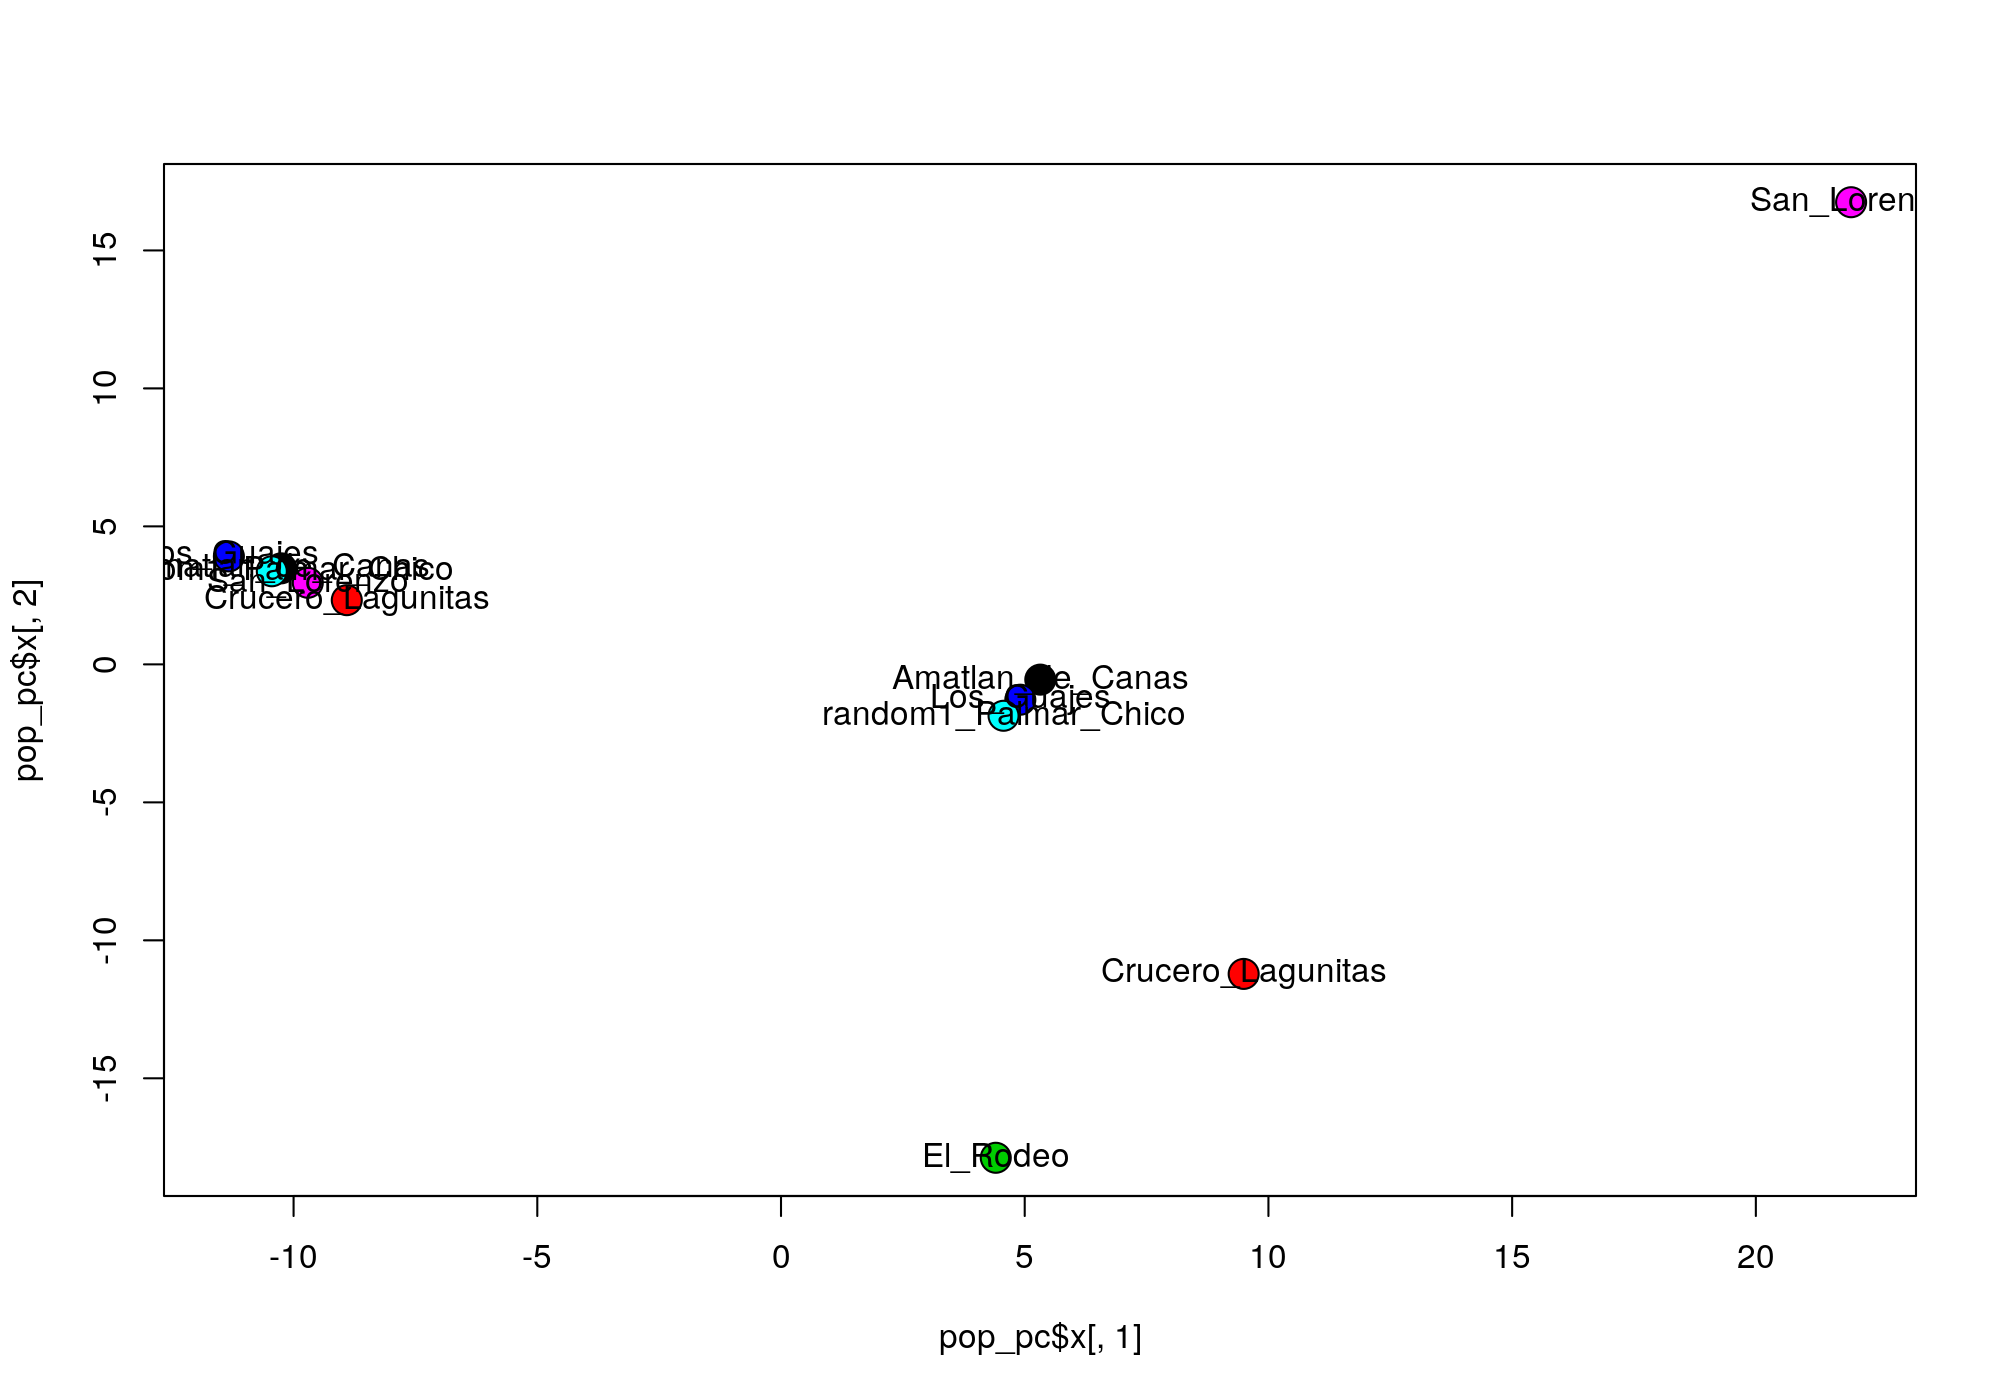

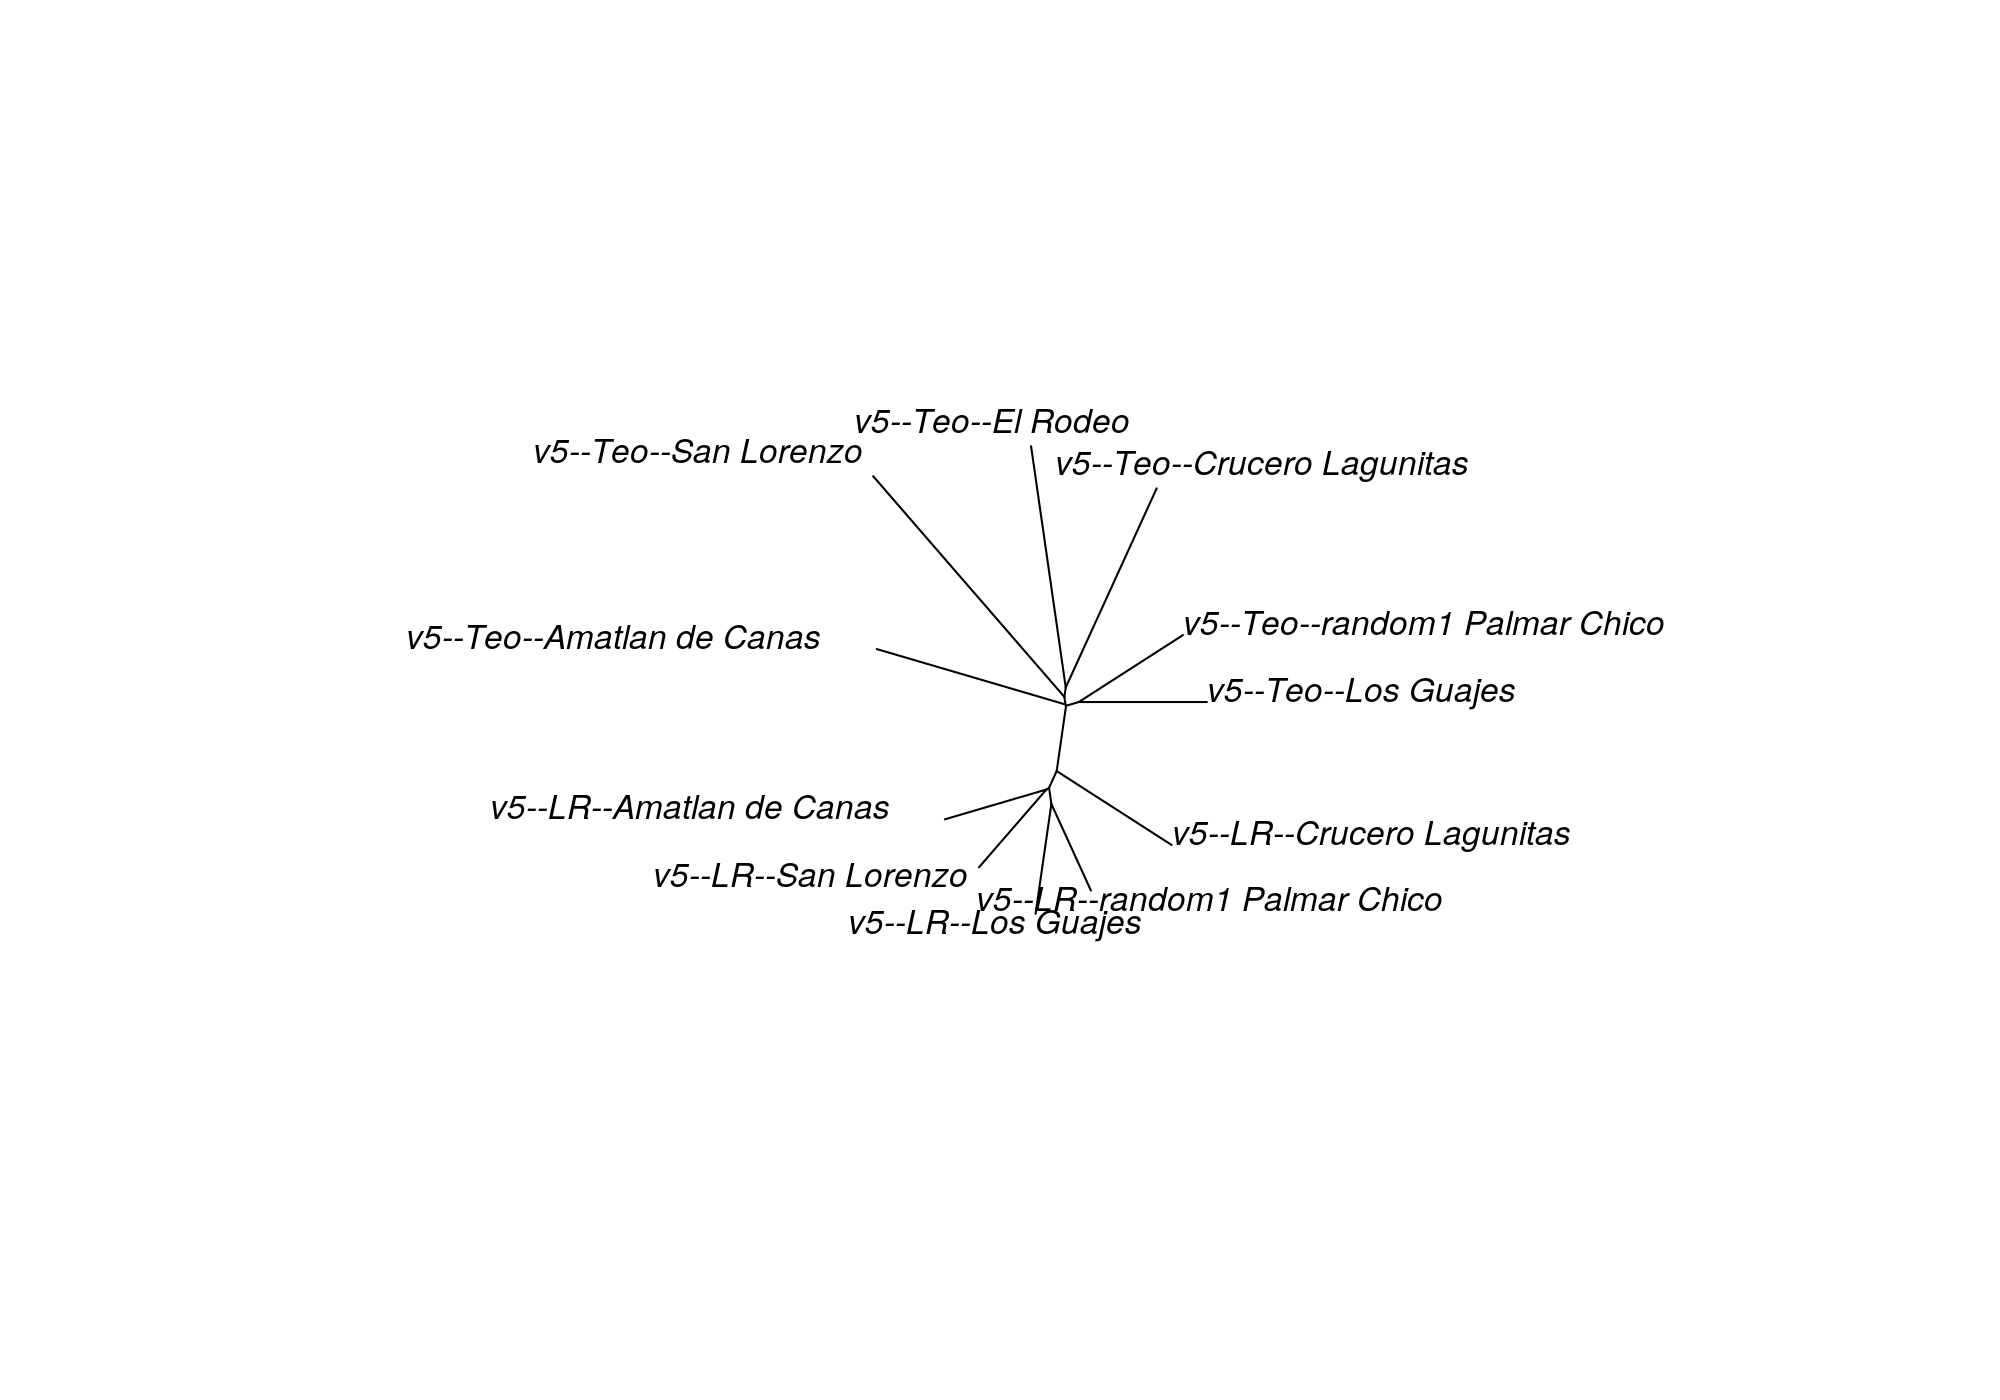

In [273]:
pop_types <- (names(neutral_freqs)[-c(1:3)] %>% str_remove_all('v5--') %>% str_split('--', simplify = TRUE))[,1]
pops <- (names(neutral_freqs)[-c(1:3)] %>% str_remove_all('v5--') %>% str_split('--', simplify = TRUE))[,2]
pop_pc <- neutral_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t() %>% 
    prcomp()

plot(pop_pc$x[,1], pop_pc$x[,2], bg = factor(pops), pch = 21, cex = 2)
text(pop_pc$x[,1], pop_pc$x[,2], pops)


dist_mat <- neutral_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t() %>% 
    dist()

plot.phylo(nj(dist_mat), type = "unrooted")

In [307]:
gen_map_all_chr <- read_delim("../data/map/ogut_v5.map.txt", delim = "\t") %>% 
  drop_na() %>%
  mutate(cm = cm + abs(min(cm))) %>%
  group_by(chr) %>% 
  group_modify(~{
    df1 <- slice(.x, -nrow(.x))
    df2 <- slice(.x, -1)
    to_keep <- df2$cm > df1$cm & df2$pos > df1$pos
    df1 <- df1[to_keep, ]
    df2 <- df2[to_keep, ]
    cm_mb <- tibble(cm_mb = 1e6*(df2$cm - df1$cm)/(df2$pos - df1$pos))
    cm_bp <- tibble(rr = (df2$cm - df1$cm)/(df2$pos - df1$pos)/100)
    bind_cols(df2, cm_mb, cm_bp)
  }) %>% 
  mutate(chr = paste0("chr", chr))


median(gen_map_all_chr$rr)

get_rr <- function(genetic_df, sweep_chr, sweep_positions){
  chr_df <- filter(genetic_df, chr == sweep_chr)
  median(approx(x = chr_df$pos, y = chr_df$rr, xout = sweep_positions)$y)
}



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  chr = col_double(),
  pos = col_double(),
  cm = col_double()
)




[1] 1.641221e-08

[1] 5.445458e-09

In [329]:
pos_vec <- select(sweep_freqs, end) %>% pull(end)

sweep_mat <- sweep_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t()

neut_mat <- 
    neutral_freqs %>% 
    select(-c(chrom, start, end)) %>% 
    t()

rr <- get_rr(gen_map_all_chr, "chr1", sweep_freqs$end)

param_list <-
  parameter_barge(
    Ne =  50000,
    rec = rr,
    neutral_freqs = neut_mat,
    selected_freqs = sweep_mat,
    selected_pops = sel_vec,
    positions = pos_vec,
    n_sites = 20,
    sample_sizes = rep(10, nrow(neut_mat)),
    num_bins = 100,
    sels = 10^seq(-4, 0, length.out = 20),
    times = c(1e2, 1e4, 1e6),
    gs = 10^seq(-3, -1, length.out = 3),
    migs = 10^(seq(-4, -2, length.out = 2)),      
    sources = sel_vec,
    locus_name = s_file,
    cholesky = TRUE
  )


In [330]:
head(param_list$locus_name)

[1] "../data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start240038515_end240233339_pops1-2-3-4-5-7.txt"

In [312]:
mode_wrapper <- function(barge, mode) {
       cle_out <- try(mode_cle(barge, mode))
       if(class(cle_out)[1] == 'try-error'){
           barge$cholesky  <- FALSE
           cle_out <- suppressWarnings(mode_cle(barge, mode))
           barge$cholesky  <- TRUE
       }
    return(cle_out)
}

t <- Sys.time()
#fit composite likelihood models
print("neutral")
neut_cle <- mode_wrapper(param_list, mode = "neutral")
print("ind")
ind_cle <- mode_wrapper(param_list, mode = "independent")
print("standing")
sv_cle <- mode_wrapper(param_list, mode = "standing")
print("mig")
mig_cle <- mode_wrapper(param_list, mode = "migration")

Sys.time() - t

[1] "neutral"
[1] "ind"
[1] "standing"
[1] "mig"


Time difference of 6.302988 mins

In [352]:
#neut <- unique(neut_cle$cle)

#merge data frame of all fit models
all_mods <-
  bind_rows(
    ind_cle,
    mig_cle,
    sv_cle
  ) %>% 
    mutate(sel_pop_ids = paste(FREQ_POPS[sel_vec+3], collapse = "; "),
           neut_cle = unique(neut_cle$cle)) 
    
#max composite likelihood estimate 
#of all params over all models  
all_mods %>%
  group_by(model) %>%    
  filter(cle == max(cle,na.rm=T)) %>% 
  mutate(mcle = cle - neut_cle) %>% 
  ungroup() %>%   
  mutate(mcle_delta = mcle - max(mcle)) %>% 
  arrange(desc(mcle))


best_mcle <- all_mods %>%
  group_by(model) %>%    
  summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
  ungroup()  %>% 
  arrange(desc(mcle))

best_mcle
(best_mod <- best_mcle %>% slice(1) %>% pull(model))


write_delim(x = all_mods, file = "test.out", delim = "\t")

selected_sites,sels,cle,locus,gs,times,migs,sources,sel_pops,model,sel_pop_ids,neut_cle,mcle,mcle_delta
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
240068601,0.0006951928,4853.426,test_locus,NA,NA,0.01,7,1-2-3-4-5-7,migration,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--random1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--Crucero_Lagunitas,4683.722,169.70370,0.00000
240078629,0.0018329807,4822.615,test_locus,0.01,100,NA,NA,1-2-3-4-5-7,standing,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--random1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--Crucero_Lagunitas,4683.722,138.89312,-30.81058
240068601,0.0001000000,4669.598,test_locus,NA,NA,NA,NA,1-2-3-4-5-7,independent,v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--random1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--Crucero_Lagunitas,4683.722,-14.12414,-183.82784


`summarise()` has grouped output by 'model'. You can override using the `.groups` argument.



model,mcle
<chr>,<dbl>
migration,169.7037
migration,169.7037
migration,169.7037
migration,169.7037
migration,169.7037
migration,169.7037
migration,169.7037
migration,169.7037
migration,169.7037


[1] "migration"

`summarise()` has grouped output by 'selected_sites', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sels', 'model'. You can override using the `.groups` argument.



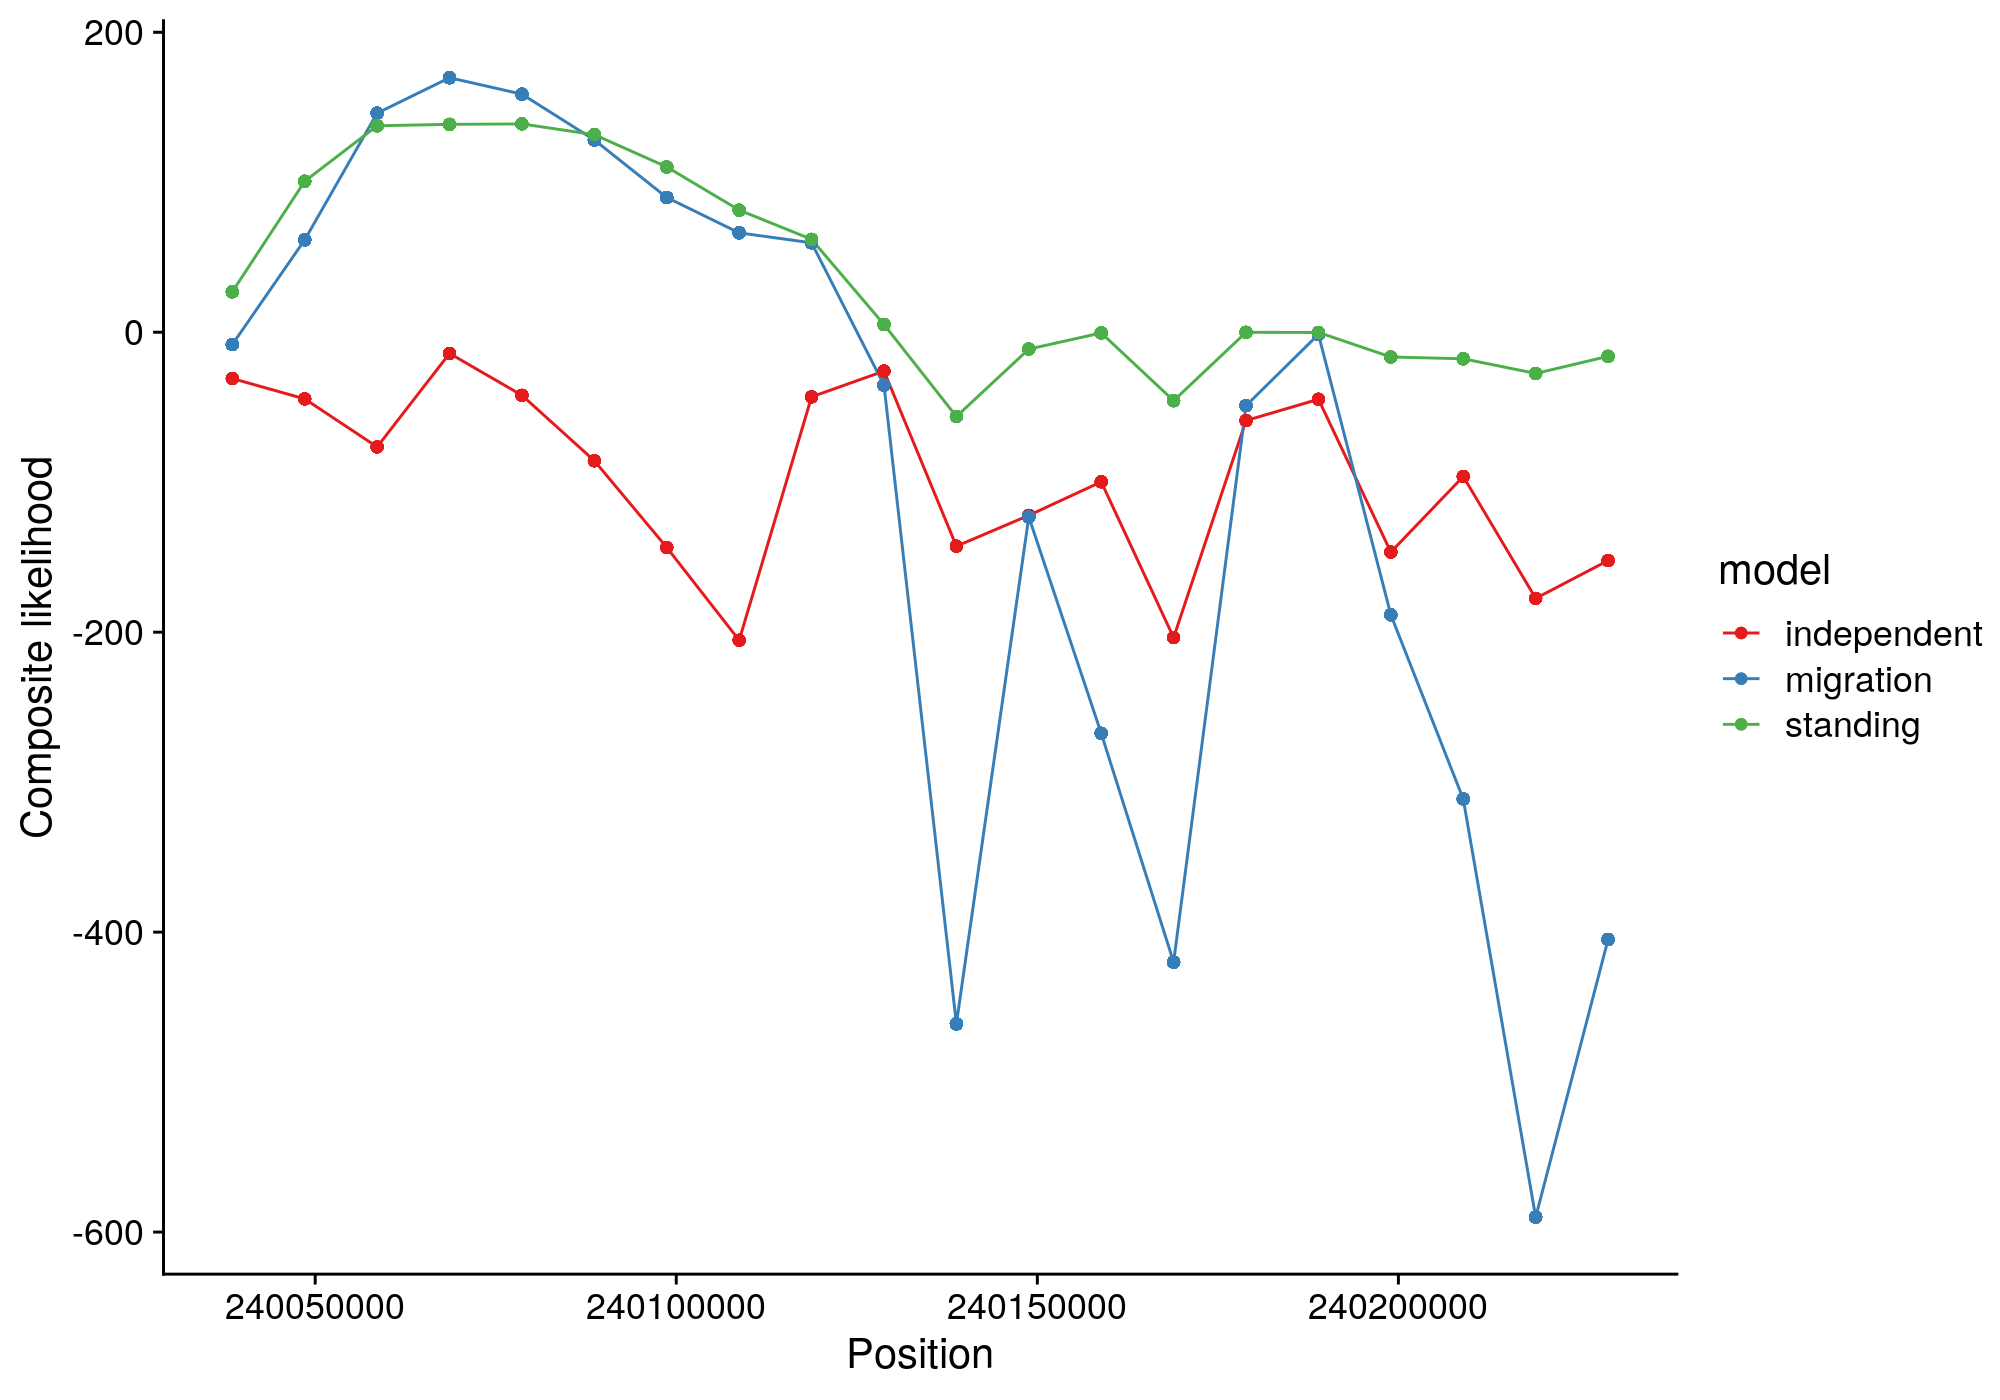

`summarise()` has grouped output by 'migs', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sources', 'model'. You can override using the `.groups` argument.



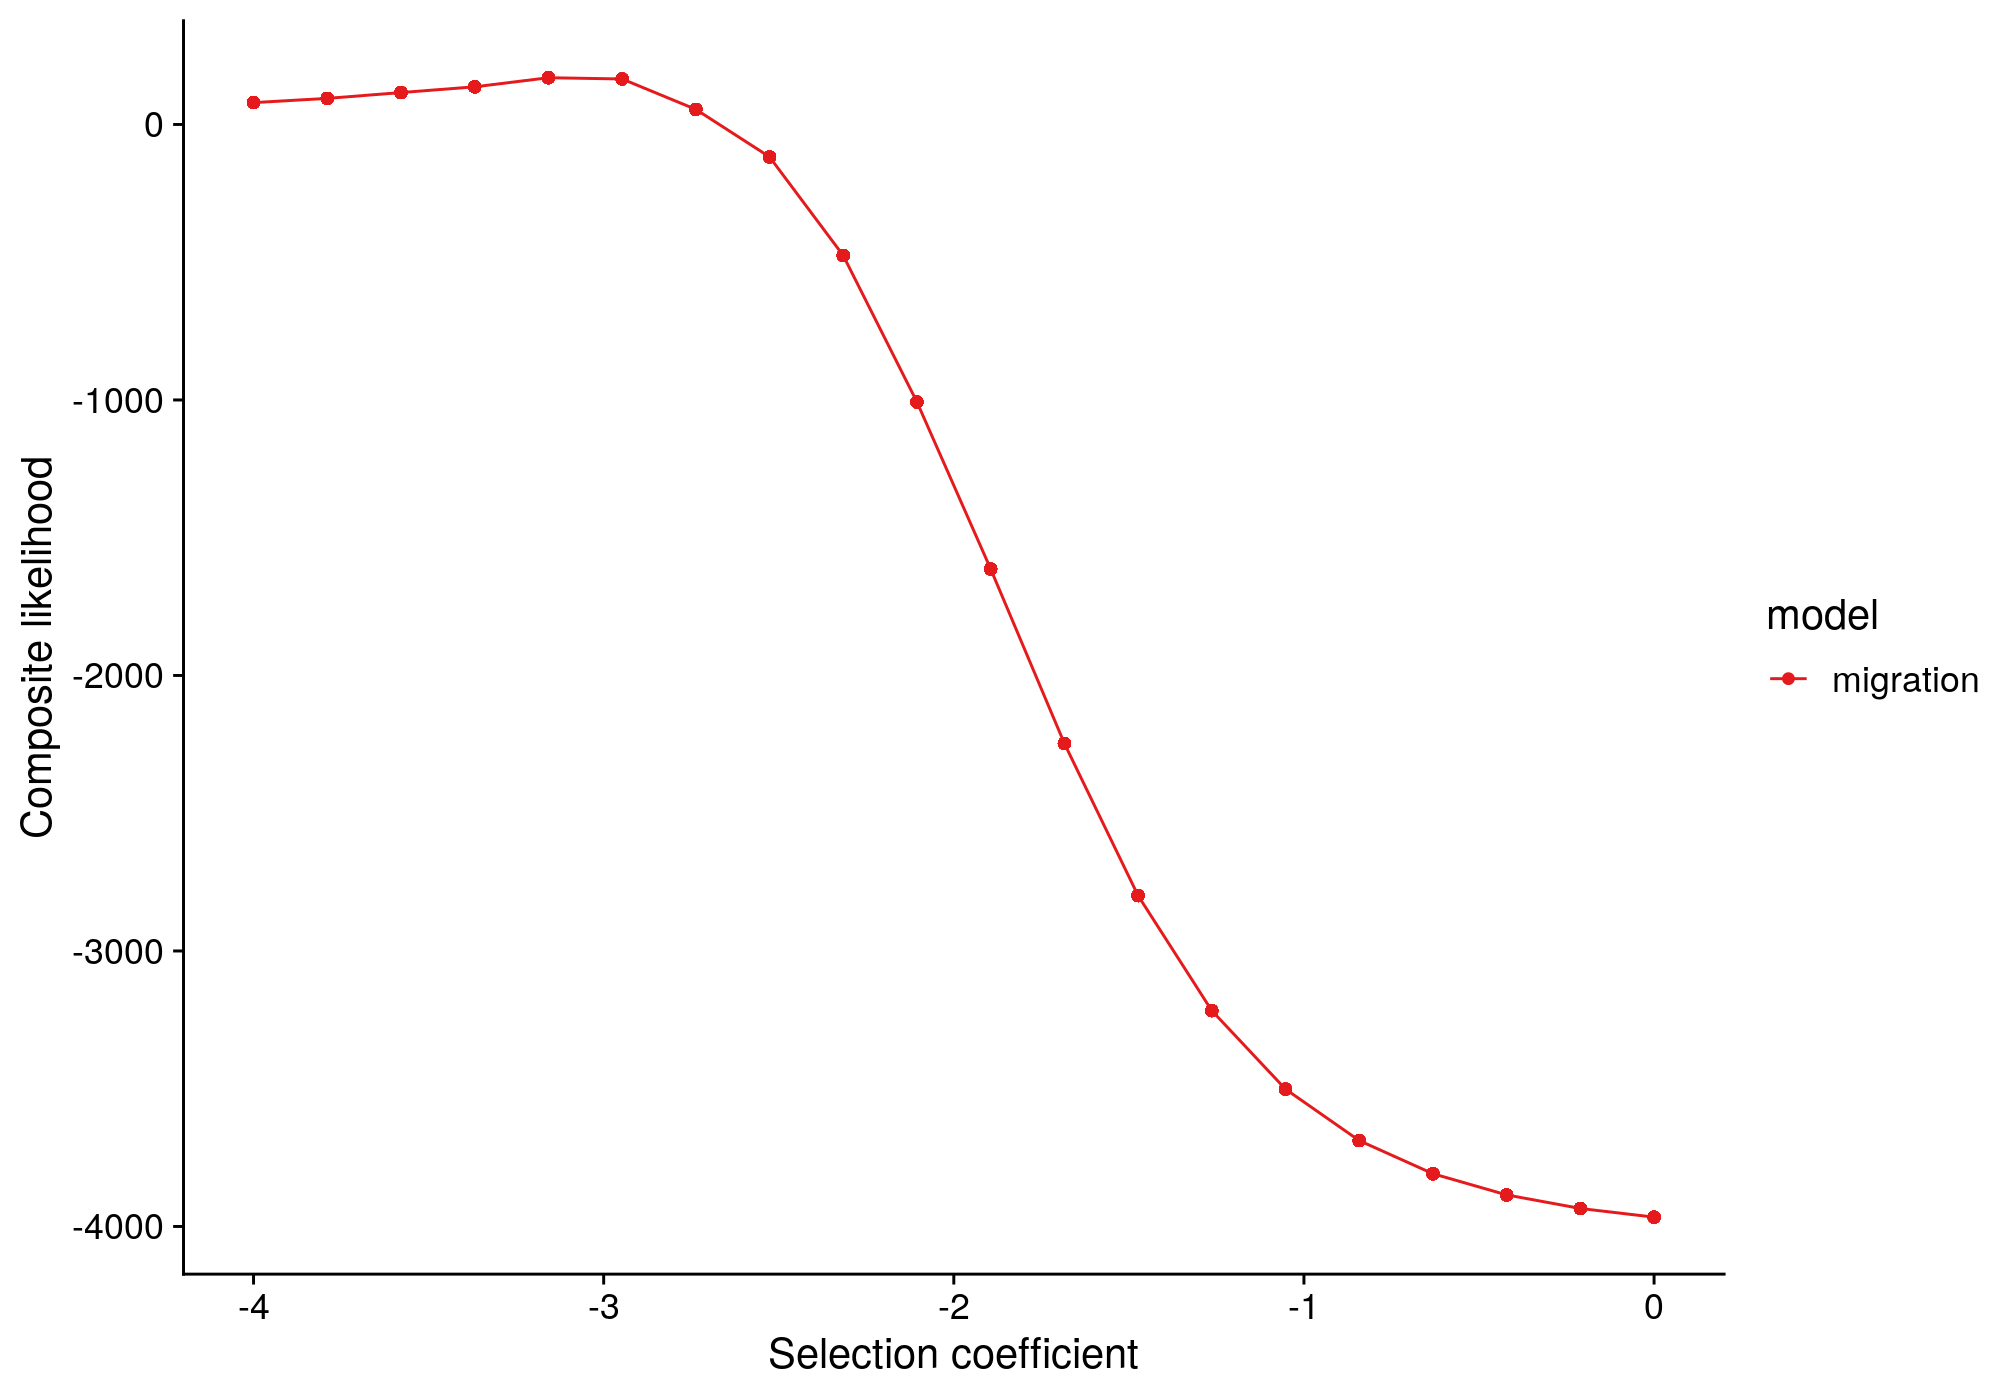

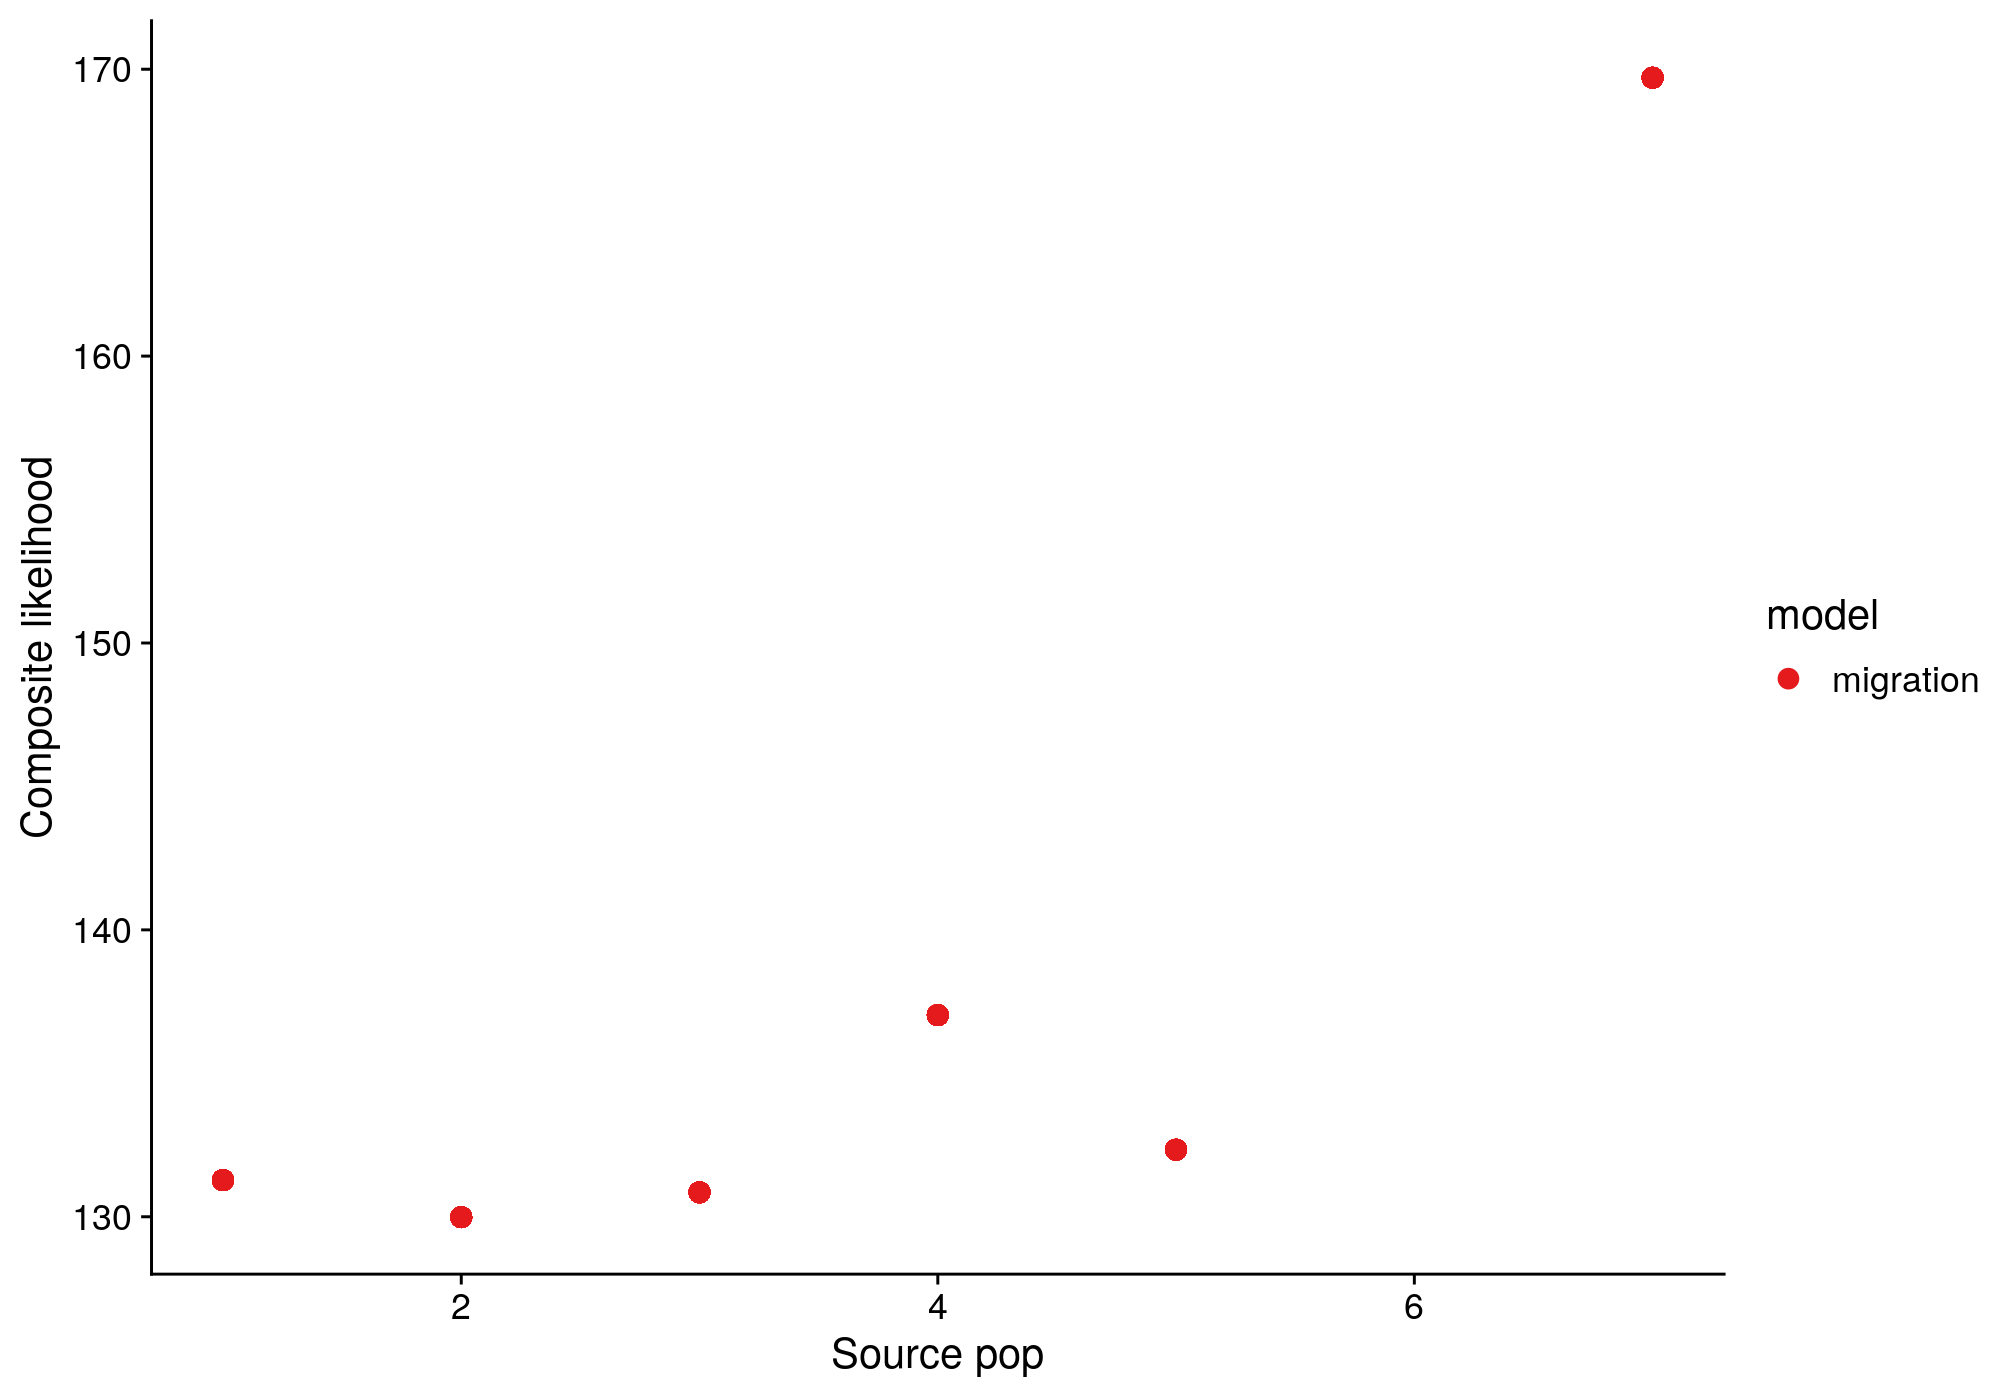

In [350]:

all_mods %>%
  group_by(selected_sites, model) %>%
  #filter(model == best_mod) %>% 
  summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
  ggplot(aes(selected_sites, mcle, colour = model)) +
  geom_line() +
  geom_point() +
  xlab("Position") +
  ylab("Composite likelihood") +
  scale_color_brewer(palette = "Set1")


#visualize likelihood surface wrt selection coefficients
all_mods %>%
  group_by(sels, model) %>%
  filter(model == best_mod) %>% 
  summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
  ggplot(aes(log10(sels), mcle, colour = model)) +
  geom_line() +
  geom_point() +
  ylab("Composite likelihood") +
  xlab("Selection coefficient") +
  scale_color_brewer(palette = "Set1") 

if (best_mod == "standing"){
    
    #visualize likelihood surface wrt age
    a  <- all_mods %>%
      group_by(times, model) %>%
      filter(model == best_mod) %>% 
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ggplot(aes(log10(times), mcle, colour = model)) +
      geom_line() +
      geom_point() +
      ylab("Composite likelihood") +
      xlab("Age") +
      scale_color_brewer(palette = "Set1") 
    
    
    #visualize likelihood surface wrt age
    b <- all_mods %>%
      group_by(gs, model) %>%
      filter(model == best_mod) %>% 
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ggplot(aes(gs, mcle, colour = model)) +
      geom_line() +
      geom_point() +
      ylab("Composite likelihood") +
      xlab("Initial allele frequency") +
      scale_color_brewer(palette = "Set1") 
    
    a / b

    
} else if(best_mod == "migration"){
     a  <- all_mods %>%
      group_by(migs, model) %>%
      filter(model == best_mod) %>% 
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ggplot(aes(log10(migs), mcle, colour = model)) +
      geom_line() +
      geom_point() +
      ylab("Composite likelihood") +
      xlab("Migration rate") +
      scale_color_brewer(palette = "Set1") 
    
    b  <- all_mods %>%
      group_by(sources, model) %>%
      filter(model == best_mod) %>% 
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ggplot(aes(sources, mcle, colour = model)) +
      geom_point(size = 3) +
      ylab("Composite likelihood") +
      xlab("Source pop") +
      scale_color_brewer(palette = "Set1") 

    b
}


In [326]:
sel_vec
paste(FREQ_POPS[sel_vec+3], collapse = "; ")

[1] 1 2 3 4 5 7

[1] "v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--random1_Palmar_Chico; v5--LR--San_Lorenzo; v5--Teo--Crucero_Lagunitas"